##  Try knn and other algorithms

- SGD Classifier
- Nearest neighbors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB

### Read in the data from Kelsey's file

In [2]:
ddir = "data/"
tcefile = "TESS_ML_20240412.txt"
columns = ["pass","win","type","injnum","period","tzero","power","dur","depth","snr","deptest1","deptest2",
           "stmass","stradius","chisq",
           "bicft","bicplus","bicminus","snrshape","noise","depth_shape2","depth_shape3","mindBIC",
           "nloops","npoints",
           "nintransit","26","27","28","29","30","31",
           "Tmag","Teff","logg","injrec","trprob"]
tces = pd.read_csv(ddir+tcefile, names=columns)

In [3]:
# This is how well Jason's RF runs written as a confusion matrix
#Originally Jason/Kelsey Confusion Matrix
injected = tces['injrec'] == 1

for prob in np.arange(0.1,1,.2):
    jasonpassed = tces['trprob'] > prob  #This is arbitrary

    num00 = len(tces[~injected & ~jasonpassed])
    num01 = len(tces[~injected & jasonpassed])
    num10 = len(tces[injected & ~jasonpassed])
    num11 = len(tces[injected & jasonpassed])

    print("   ==>  For the Probability %f:" % prob)
    #print([num00,num01],"\n",[num10,num11])

    print(100*np.array([num00,num01])/(num00+num01),"\n",
          100*np.array([num10,num11])/(num10+num11))

   ==>  For the Probability 0.100000:
[98.07989365  1.92010635] 
 [  0. 100.]
   ==>  For the Probability 0.300000:
[99.52863308  0.47136692] 
 [ 3.127238 96.872762]
   ==>  For the Probability 0.500000:
[99.8745518  0.1254482] 
 [ 7.25113392 92.74886608]
   ==>  For the Probability 0.700000:
[9.99920425e+01 7.95753485e-03] 
 [12.84912867 87.15087133]
   ==>  For the Probability 0.900000:
[100.   0.] 
 [24.28383862 75.71616138]


Only some were used by Kelsey and Jason to vet, we will start with those for training, 
I'm not sure I entirely agree with choices.

In [4]:
metrics=[ "period",
         "power","dur","depth","snr",
         #"deptest1","deptest2",
         "chisq",
         "bicft","bicplus","bicminus","snrshape",
         "noise","depth_shape2","depth_shape3",
         "mindBIC","nloops",
         #"npoints","nintransit",
         #"26","27","28","29","30","31",
         #"Tmag", "logg", "Teff"
         ]

X = np.array(tces[metrics])
X[~np.isfinite(X)] = -9999

#Here we define the test and training sets using a routine written by Scikitlearn
#X contains the metrics or features and y contains the answers (0,1)
X_train, X_test, y_train, y_test = train_test_split(X, tces['injrec'], test_size=0.3)
X_train[0]

array([1.3637813e+01, 4.1300000e-04, 1.2274000e-01, 1.1966000e-02,
       7.5541930e+00, 2.4500000e+00, 4.6660000e+01, 1.0580000e+01,
       1.1440000e+01, 7.6000000e+00, 1.1131000e-02, 4.0000000e-01,
       5.0000000e-01, 1.0580000e+01, 7.8000000e+01])

In [6]:
rf = RandomForestClassifier(n_estimators=40,max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)
scores= cross_val_score(rf, X_train, y_train, cv=6)
print("Cross Validation Score mean: %f" % scores.mean())

Cross Validation Score mean: 0.989589


Accuracy: 0.9899879913769406


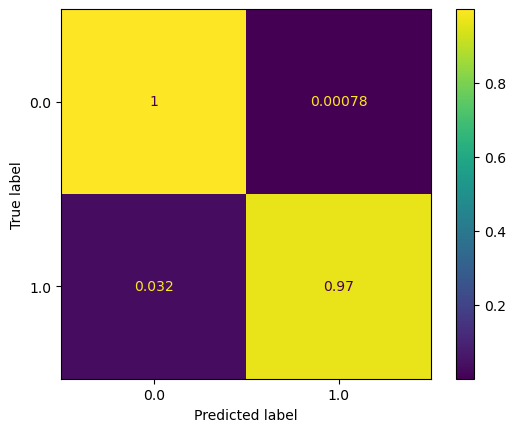

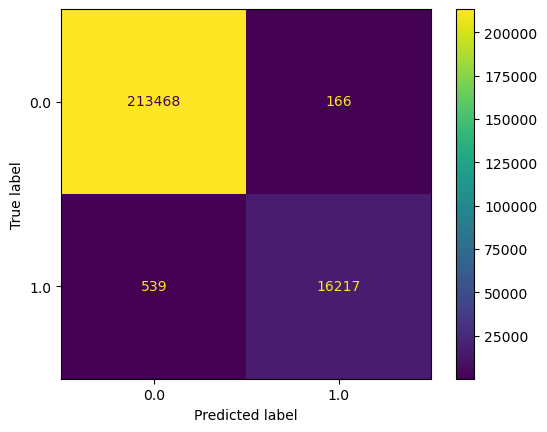

In [7]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)

_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(rf, X, tces['injrec'])

## KNN example
Using a stochastic gradient descent classifier. Using a modified huber and elasticnet penalty seemed to give the best answers. Including period in the features.

In [75]:
clf = SGDClassifier(loss="modified_huber", penalty="event", max_iter=700)

clf.fit(X_train, y_train)

SGDClassifier(loss='modified_huber', max_iter=700)

In [83]:
scores= cross_val_score(clf, X_train, y_train, cv=9)
print("Cross Validation Score mean: %f" % scores.mean())

Cross Validation Score mean: 0.971942


In [84]:
y_pred = clf.predict(X_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

Accuracy: 0.9725248491688008


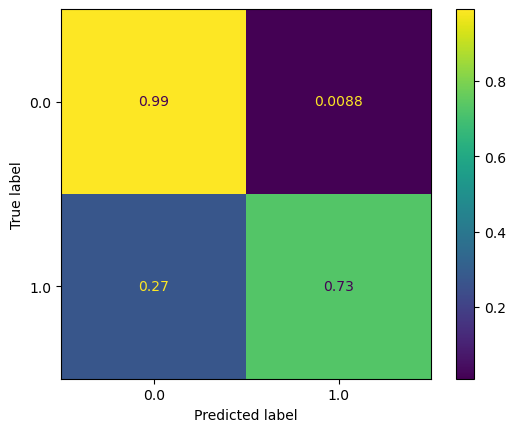

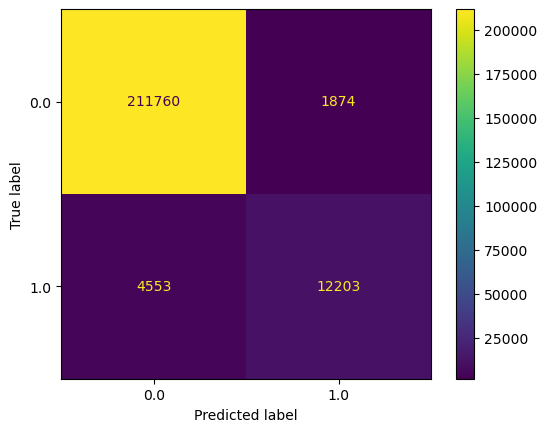

In [85]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)
_ = ConfusionMatrixDisplay.from_estimator(clf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(clf, X, tces['injrec'])


In [50]:
y_all = clf.predict(X)
y_prob = clf.predict_proba(X)
tces['newSGC'] = y_all
tces['newSGCprob'] = y_prob[:,0]  #Probability it is class "transit"

In [74]:
y_prob[2550:2650,0]

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [87]:
clf = GaussianNB()

y_pred = clf.fit(X_train, y_train).predict(X_test)

Accuracy: 0.9676635270628066


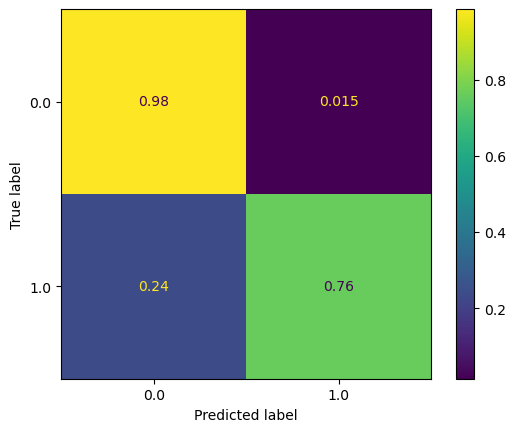

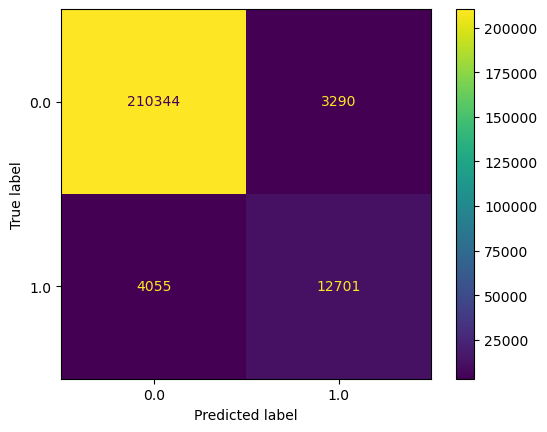

In [88]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_pred=y_pred, y_true = y_test)
_ = ConfusionMatrixDisplay.from_estimator(clf, X, tces['injrec'], normalize='true')
_ = ConfusionMatrixDisplay.from_estimator(clf, X, tces['injrec'])


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(.1, 100))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

Text(0, 0.5, 'Susan Score')

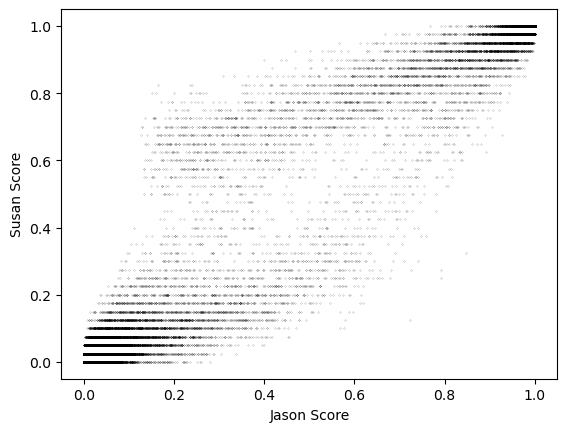

In [13]:
#Compare to Jason's RF for individual cases.
injected = tces['injrec'] == 1
jasonpassed = tces['trprob'] > 0.5
rfpassed = tces['newRFprob'] >0.5

plt.plot(tces['trprob'], tces['newRFprob'],'.k', ms=0.2)
plt.xlabel('Jason Score')#Compare to Jason's RF for individual cases.
injected = tces['injrec'] == 1
falsepos = tces['injrec'] == 0

plt.figure(figsize=(12,3.3))
plt.subplot(131)
plt.plot(tces['trprob'], tces['newRFprob'],'.k', ms=0.2)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.ylabel('Susan Score')
plt.subplot(132)
plt.plot(tces[injected]['trprob'],tces[injected]['newRFprob'], '.r',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected only')

plt.subplot(133)
plt.plot(tces[falsepos]['trprob'],tces[falsepos]['newRFprob'], '.b',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected only')
plt.tight_layout
plt.ylabel('Susan Score')

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

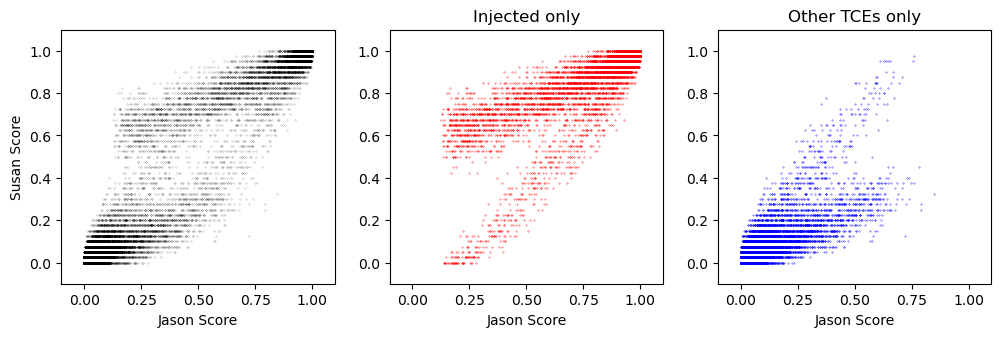

In [17]:
#Compare to Jason's RF for individual cases.
injected = tces['injrec'] == 1
falsepos = tces['injrec'] == 0

plt.figure(figsize=(12,3.3))
plt.subplot(131)
plt.plot(tces['trprob'], tces['newRFprob'],'.k', ms=0.2)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.ylabel('Susan Score')
plt.subplot(132)
plt.plot(tces[injected]['trprob'],tces[injected]['newRFprob'], '.r',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Injected only')

plt.subplot(133)
plt.plot(tces[falsepos]['trprob'],tces[falsepos]['newRFprob'], '.b',ms=0.5)
plt.xlabel('Jason Score')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.title('Other TCEs only')
plt.tight_layout

## Compare the probability score with the binary score.
Does it just apply a threshold to determine the binary score.  Plotting 0,1 vs probability should show that.
Apparently a threshold of 0.5 in the probability score is the same as the binary result.

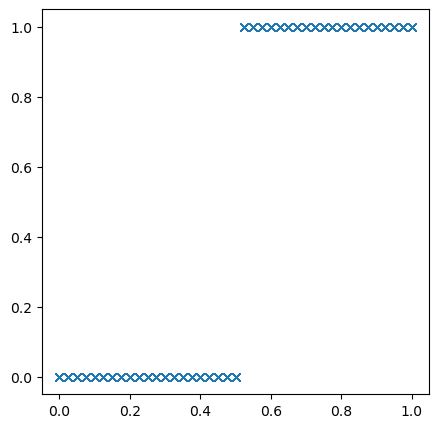

In [15]:
plt.figure(figsize=(5,5))
plt.plot(tces['newRFprob'], tces['newRF'],'x')

## Let's learn somethign about the ones I'm getting wrong.

In [26]:
tces.columns

Index(['pass', 'win', 'type', 'injnum', 'period', 'tzero', 'power', 'dur',
       'depth', 'snr', 'deptest1', 'deptest2', 'stmass', 'stradius', 'chisq',
       'bicft', 'bicplus', 'bicminus', 'snrshape', 'noise', 'depth_shape2',
       'depth_shape3', 'mindBIC', 'nloops', 'npoints', 'nintransit', '26',
       '27', '28', '29', '30', '31', 'Tmag', 'Teff', 'logg', 'injrec',
       'trprob', 'newRF', 'newRFprob'],
      dtype='object')

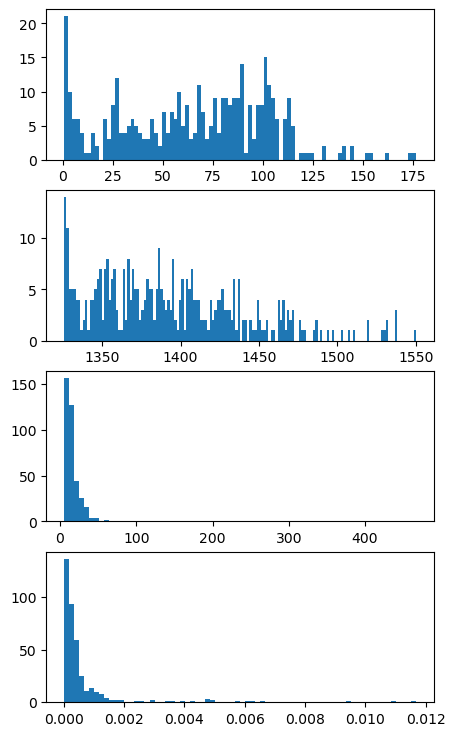

In [32]:
want = injected & ~rfpassed
extces = tces[want]

plt.figure(figsize=(5,9))
plt.subplot(4,1,1)
_,_,_ = plt.hist(extces['period'], 90)
plt.subplot(4,1,2)
_,_,_ = plt.hist(extces['tzero'], 150)
plt.subplot(4,1,3)
_,_,_ = plt.hist(extces['snr'], 70)
plt.subplot(4,1,4)
_,_,_ = plt.hist(extces['power'], 70)